This notebook compare a token of actual market and argumented data before creating Dataset with a data argument

In [1]:
import os
import time

try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path='/content/drive'
  base_folder = "/Data/FX"
  data_folder = f'{mount_path}/My Drive{base_folder}'
  drive.mount(mount_path)
else:
  base_folder = '../../Data/'
  data_folder = os.path.join(base_folder, "fx")

Mounted at /content/drive


# Deterministic Multi Agent Simulation

In [235]:
import random
from collections.abc import Iterable

import numpy as np
import pandas as pd


class DeterministicDealerModelV1:

    def __init__(self, num_agent, max_volatility = 0.02, min_volatility = 0.01, trade_unit=0.001, initial_price=100, spread=1, initial_positions=None, tick_time=0.001,
                 experimental=False, time_noise_method=None, max_noise_factor=1) -> None:
        # min_vol should be greater than 0
        # agent tendency: agent change his order prices based on the tendency
        tendency = pd.Series([random.uniform(min_volatility, max_volatility) for i in range(num_agent)], dtype=float)
        if trade_unit < 1:
            do_round = True
            decimal = 0.1
            decimal_num = 1
            while True:
                check = trade_unit / decimal
                if check >= 1 - trade_unit:
                    break
                decimal *= 0.1
                decimal_num += 1
                if decimal_num > 100:
                    do_round = False
                    break
            if do_round is True:
                tendency = tendency.round(decimal_num)
        prices = pd.Series([random.uniform(initial_price, initial_price + spread) for i in range(num_agent)], dtype=float)
        if initial_positions is None:
            position_trends = pd.Series([random.choice([-1, 1]) for i in range(num_agent)], dtype=int)
        elif len(initial_positions) == num_agent:
            position_trends = pd.Series(initial_positions, dtype=int)
        else:
            raise ValueError("initial position is invalid.")
        self.agent_df = pd.concat([tendency, position_trends, prices], axis=1, keys=["tend", "position", "price"], names=["id"])
        self.spread = spread
        self.market_price = initial_price + self.spread
        self.__initial_price = initial_price
        self.__min_vol = min_volatility
        self.__max_vol = max_volatility
        self.trade_unit = trade_unit
        self.tick_time = 0.0
        self.tick_time_unit = tick_time
        self.max_noise_factor = max_noise_factor
        if experimental is True:
            self.simulate = self.__freq_advance_simulate
        else:
            self.simulate = self.__ref_simulate

        if time_noise_method is None:
          self.__get_time_noise = lambda : 1
        elif time_noise_method == "uniform":
          self.__get_time_noise = self.__get_uniform_noise
        elif time_noise_method == "exp":
          self.__noise_factors = list(range(1, self.max_noise_factor + 1))
          self.__noise_weights = [1/(i+1) for i in range(self.max_noise_factor)]
          self.__get_time_noise = self.__get_weighted_noise
        elif callable(time_noise_method) is True:
          self.__get_time_noise = time_noise_method
        else:
          raise ValueError("this method is not defined")

    def __get_uniform_noise(self):
      random_number = random.uniform(1, self.max_noise_factor)
      return random_number

    def __get_weighted_noise(self):
        random_number = random.choices(self.__noise_factors, weights=self.__noise_weights)[0]
        return random_number

    def advance_order_price(self):
        self.agent_df.price += self.agent_df.position * self.agent_df.tend
        # print("*kept*")
        # print(self.agent_df)
        return self.agent_df.price

    def contruct(self):
        ask_agents = self.agent_df.loc[self.agent_df.position == 1]
        bought_agent_id = ask_agents.price.idxmax()
        ask_order_price = ask_agents.price[bought_agent_id]

        bid_agents = self.agent_df.loc[self.agent_df.position == -1]
        sold_agent_id = bid_agents.price.idxmin()
        bid_order_price = bid_agents.price[sold_agent_id] + self.spread

        if ask_order_price >= bid_order_price:
            # print("---contructed!!---")
            self.market_price = (((ask_order_price + bid_order_price)/2) // self.trade_unit) * self.trade_unit
            # print(bought_agent_id, sold_agent_id)
            self.agent_df.loc[bought_agent_id, "position"] = -1
            self.agent_df.loc[sold_agent_id, "position"] = 1
            # print(self.agent_df)
            return self.market_price
        return None


    def __ref_simulate(self, total_seconds):
        self.price_history = [self.market_price]
        tick_times = [self.tick_time]
        while self.tick_time < total_seconds:
            random_span_factor = self.__get_time_noise()
            self.tick_time += self.tick_time_unit * random_span_factor
            price = self.contruct()
            if price is not None:
                # print(self.tick_time)
                self.price_history.append(price)
                tick_times.append(self.tick_time)
            else:
                self.advance_order_price()
        price_hist_df = pd.DataFrame(self.price_history, columns=["price"])
        tick_times = np.asarray(tick_times)
        self.tick_time = 0
        return price_hist_df, tick_times

    def __freq_advance_simulate(self, total_seconds):
        self.price_history = [self.market_price]
        tick_times = [self.tick_time]
        while self.tick_time < total_seconds:
            random_span_factor = self.__get_time_noise()
            self.tick_time += self.tick_time_unit * random_span_factor
            self.advance_order_price()
            price = self.contruct()
            if price is not None:
                # print(self.tick_time)
                self.price_history.append(price)
                tick_times.append(self.tick_time)
        price_hist_df = pd.DataFrame(self.price_history, columns=["price"])
        tick_times = np.asarray(tick_times)
        self.tick_time = 0
        return price_hist_df, tick_times


class DeterministicDealerModelV3(DeterministicDealerModelV1):

    def __init__(self, num_agent, max_volatility = 0.02, min_volatility = 0.01, trade_unit=0.001, initial_price=100, spread=1, initial_positions=None, tick_time=0.001,
                 experimental=False, time_noise_method=None, max_noise_factor=1,
                 dealer_sensitive=None, wma=1, dealer_sensitive_min=-3.5, dealer_sensitive_max=-1.5
                 ) -> None:
        """_summary_

        Args:
            dealer_sensitive (int|Iterable, optional): this values represent sensitivity of each agent for past prices. greater/less than 0 means follower/contrarian. Defaults to None and initialized with random values by normal dist with mean and sigma
            wma (int|Iterable, optional): this values represent how long agents will be affected by past values. Defaults to 1.
        """
        super().__init__(num_agent, max_volatility, min_volatility, trade_unit, initial_price, spread, initial_positions, tick_time,
                         experimental=experimental, time_noise_method=time_noise_method, max_noise_factor=max_noise_factor)
        self.price_history = [self.market_price]
        self.tick_times = [self.tick_time]

        if dealer_sensitive is None:
            # create array with random values between -1 to 1
            self.dealer_sensitive = np.asarray([random.uniform(dealer_sensitive_min, dealer_sensitive_max) for i in range(num_agent)])
        elif isinstance(dealer_sensitive, (int, float)):
            # create array with fixed value
            self.dealer_sensitive = np.asarray([ dealer_sensitive for i in range(num_agent)])
        elif isinstance(dealer_sensitive, Iterable):
            # use provided array
            self.dealer_sensitive = np.asanyarray(dealer_sensitive)
        else:
            raise TypeError("dealer_sensitive must be either float or Iterable object")

        if isinstance(wma, int):
            # create weight array with random values between 0 to 1
            self.weight_array = np.asarray([random.uniform(0, 1) for i in range(wma)])
            self.__total_weight = np.sum(self.weight_array)
            self.wma = wma
        elif isinstance(wma, Iterable):
            #  use wma as weight array
            self.weight_array = np.asarray(wma)
            self.__total_weight = np.sum(self.weight_array)
            self.wma = len(wma)
        else:
            raise TypeError("wma must be either int or Iterable object")


    def __wma(self):
        if len(self.price_history) >= self.wma + 1:
            wma_price = 0.0
            for i in range(1, self.wma+1):
                price_diff = self.price_history[-i] - self.price_history[-i -1]
                wma_price += (self.weight_array[i-1] * price_diff)
            return wma_price/self.__total_weight
        else:
            return 0

    def advance_order_price(self):
        follow_factors = self.dealer_sensitive * self.__wma()
        self.agent_df.price += self.agent_df.position * self.agent_df.tend + follow_factors
        return self.agent_df.price

## Investigation

In [5]:
import matplotlib.pyplot as plt

# Loaad Actual Market Data
tick_df = pd.read_csv(f"{data_folder}/OANDA_2021_tick.zip", index_col=0, parse_dates=True)
# remove market holiday
out_condition = 3600 * 24
time_diff = (tick_df.index[1:] - tick_df.index[:-1]).total_seconds()
time_diff = time_diff[time_diff < out_condition]
min_span = time_diff[time_diff > 0].min()
time_span = np.round(time_diff/min_span)
mean_spread = tick_df.spread.mean()

In [8]:
start_time = time.time()
model = DeterministicDealerModelV3(1000, spread=mean_spread*100, max_volatility=0.1)
prices, ticks = model.simulate(60*30)
end_time = time.time()
elasped_time = end_time - start_time

In [9]:
def cumulative_dist(data, bins=100):
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts_prob = counts/counts.sum()
    cumulative = np.cumsum(counts_prob)
    possibilities = 1 - cumulative
    return np.array([1, *possibilities]) , np.array([1e-10, *bin_edges[1:]])

### Tick Data Comparison

In [10]:
token_length = 60
tick_src = tick_df.price.diff().iloc[1:]
tick_token_sample = tick_src.iloc[:token_length]
tick_token_sample.head()

2020-12-31 17:00:00.166    0.000
2020-12-31 17:00:00.204    0.000
2020-12-31 17:00:00.231    0.000
2020-12-31 17:00:02.442    0.001
2020-12-31 17:00:02.485    0.000
Name: price, dtype: float64

In [11]:
sim_src = prices.price.diff().iloc[1:]
sim_src.head()

1    0.000367
2   -0.009000
3    0.004000
4   -0.001000
5    0.000000
Name: price, dtype: float64

In [12]:
tick_src.describe()

count    7.315639e+07
mean     1.645516e-07
std      7.874238e-04
min     -2.510000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.600000e-01
Name: price, dtype: float64

In [13]:
# outlier is not simulated in the model. So min/max value is greater/less than market result.
sim_src.describe()

count    35089.000000
mean        -0.000001
std          0.001465
min         -0.017000
25%         -0.001000
50%          0.000000
75%          0.001000
max          0.019000
Name: price, dtype: float64

In [14]:
print('skew:', tick_src.skew())
print('kurt:', tick_src.kurtosis())

skew: -0.6811019188661228
kurt: 1899.1727622185867


In [15]:
print('skew:', sim_src.skew())
print('kurt:', sim_src.kurtosis())

skew: 0.26729235576668453
kurt: 14.044790030556115


In [16]:
mean = tick_src.mean()
std = tick_src.std()

cumulative, bin_edges = cumulative_dist(tick_src.abs(), bins=500)
num_samples = 1000
data = abs(np.random.normal(mean, std, num_samples))
n_cumulative, n_bin_edges = cumulative_dist(data)

In [17]:
mean = sim_src.mean()
std = sim_src.std()

sim_cumulative, sim_bin_edges = cumulative_dist(sim_src.abs(), bins=500)
num_samples = 1000
data = abs(np.random.normal(mean, std, num_samples))
sim_n_cumulative, sim_n_bin_edges = cumulative_dist(data)

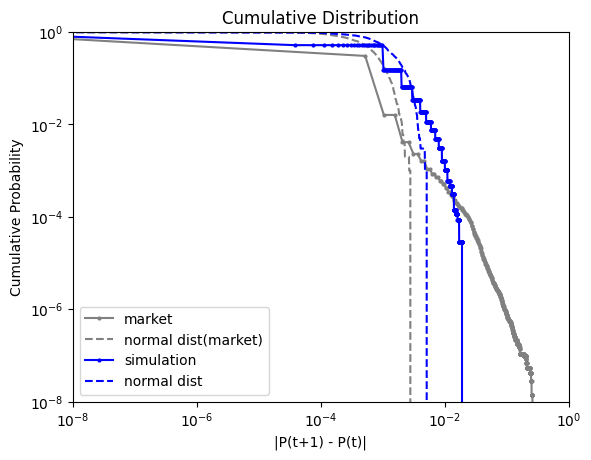

In [18]:
plt.plot(bin_edges, cumulative, color="gray", marker="o", markersize=2, label="market")
plt.plot(n_bin_edges, n_cumulative, color="gray", linestyle="--", label="normal dist(market)")

plt.plot(sim_bin_edges, sim_cumulative, color="blue", marker="o", markersize=2, label="simulation")
plt.plot(sim_n_bin_edges, sim_n_cumulative, color="blue", linestyle="--", label="normal dist")

plt.title('Cumulative Distribution')
plt.xlabel('|P(t+1) - P(t)|')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1)
plt.xlim(1e-8, 1)
plt.legend()
plt.show()

### OHLC Data Comparision

In [49]:
ohlc_min_df = tick_df.price.resample('MIN').ohlc().dropna()
ohlc_min_src = ohlc_min_df.diff().iloc[1:]
ohlc_min_src.describe()

,open,high,low,close
count,374066.000000,374066.000000,374066.000000,374066.000000
mean,0.000032,0.000032,0.000032,0.000032
std,0.010457,0.009416,0.009736,0.010401
min,-0.415000,-0.393000,-0.415000,-0.415000
25%,-0.005000,-0.004000,-0.003000,-0.005000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.005000,0.004000,0.004000,0.005000
max,0.367000,0.342000,0.370000,0.368000


#### resample data with random time noise

In [ ]:
initial_positions = [(-1)**i for i in range(1000)]
model = DeterministicDealerModelV3(1000, spread=mean_spread*100, max_volatility=0.1, initial_positions=initial_positions,
                                   time_noise_method="exp", max_noise_factor=100)
prices, ticks = model.simulate(60*300)
start_date = pd.to_datetime("2024-01-01 00:00:00.000Z")
prices.index = start_date + pd.to_timedelta(ticks, unit="S")

In [218]:
ohlc_min_sim_df = prices.resample('MIN').ohlc()
ohlc_min_sim_src = ohlc_min_sim_df.diff().iloc[1:]
ohlc_min_sim_src.describe()

price                                    
             open        high         low       close
count  300.000000  300.000000  300.000000  300.000000
mean    -0.000282   -0.000343   -0.000240   -0.000293
std      0.011064    0.008736    0.009196    0.010986
min     -0.032000   -0.041000   -0.027000   -0.030000
25%     -0.008000   -0.005000   -0.005250   -0.008000
50%     -0.000500    0.000000    0.000000    0.000000
75%      0.007000    0.005000    0.006000    0.007000
max      0.031000    0.023000    0.032000    0.025000

In [50]:
mean = ohlc_min_src.close.mean()
std = ohlc_min_src.close.std()

cumulative, bin_edges = cumulative_dist(ohlc_min_src.close.abs(), bins=500)

In [57]:
mean = ohlc_min_sim_src.price.close.mean()
std = ohlc_min_sim_src.price.close.std()

sim_cumulative, sim_bin_edges = cumulative_dist(ohlc_min_sim_src..price.close.abs(), bins=500)

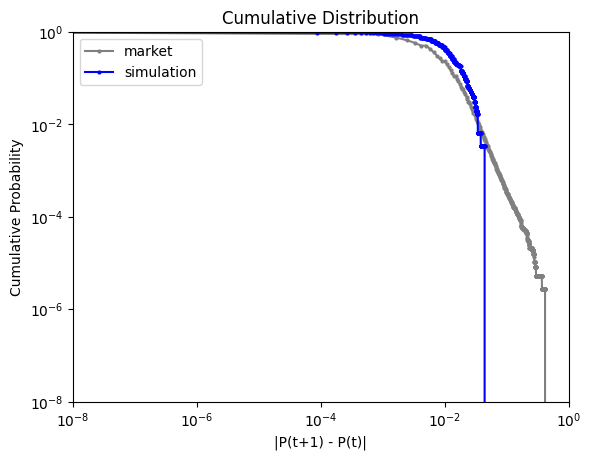

In [58]:
plt.plot(bin_edges, cumulative, color="gray", marker="o", markersize=2, label="market")
plt.plot(sim_bin_edges, sim_cumulative, color="blue", marker="o", markersize=2, label="simulation")

plt.title('Cumulative Distribution')
plt.xlabel('|P(t+1) - P(t)|')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1)
plt.xlim(1e-8, 1)
plt.legend()
plt.show()

In [70]:
def z(price_diff_srs, mean, std):
    return (price_diff_srs - mean)/std

def self_similarity(price_srs:pd.Series, k=100):
    base_mean = price_srs.mean()
    base_std = price_srs.std()
    base_z = z(price_srs, base_mean, base_std)

    sim_array = base_z.values * base_z.values
    similarities = [np.mean(sim_array)]
    sim_stds = [np.std(sim_array)]
    ks = [*range(0, k)]
    for i in ks[1:]:
        sim_array = base_z.values[i:] * base_z.values[:-i]
        mean_sim = np.mean(sim_array)
        std_sim = np.std(sim_array)
        similarities.append(mean_sim)
        sim_stds.append(std_sim)
    return ks, similarities, sim_stds

In [71]:
indices, similarities, _ = self_similarity(ohlc_min_src.close, k=20)
sim_indices, sim_similarities, _ = self_similarity(ohlc_min_sim_src.price.close, k=20)

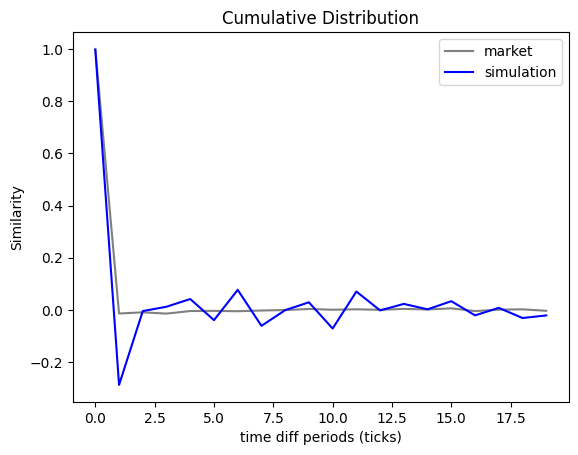

In [72]:
plt.plot(indices, similarities, color="gray", label="market")
plt.plot(sim_indices, sim_similarities, color="blue", label="simulation")
plt.title('Cumulative Distribution')
plt.xlabel('time diff periods (ticks)')
plt.ylabel('Similarity')
plt.legend()
plt.show()

In [59]:
def diffusion(price_srs, n):
    if isinstance(price_srs, pd.Series):
        diff = price_srs.diff(periods=n).dropna()
        return diff.var()
    else:
        diff = (price_srs[:-n] - price_srs[n:])
        p_mean = (diff ** 2).mean()
        mean_p = (diff.mean()) ** 2
        return p_mean - mean_p

In [67]:
periods = [i for i in range(1, 10)]
var_diffusions = np.array([diffusion(ohlc_min_src.close, period) for period in periods])
std_diffusions = np.sqrt(var_diffusions)

In [68]:
sim_var_diffusions = np.array([diffusion(ohlc_min_sim_src.price.close, period) for period in periods])
sim_std_diffusions = np.sqrt(sim_var_diffusions)

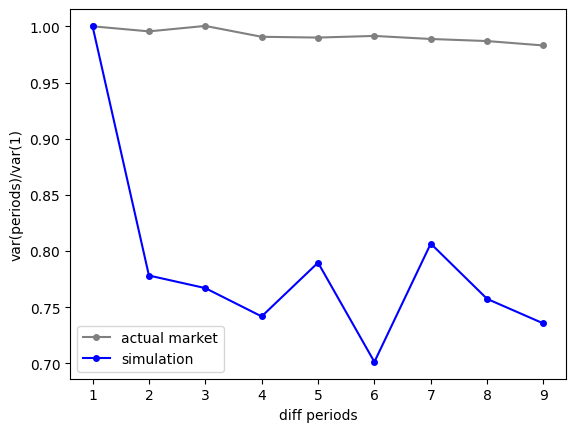

In [69]:
# creating ohlc data with noise factor with uniforme distribution is not good
plt.plot(periods, var_diffusions/var_diffusions[0], label="actual market", color="gray", linestyle="-", marker="o", markersize=4)
plt.plot(periods, sim_var_diffusions/sim_var_diffusions[0], label="simulation", color="blue", linestyle="-", marker="o", markersize=4)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("diff periods")
plt.ylabel("var(periods)/var(1)")
plt.legend()
plt.show()

In [ ]:
initial_positions = [(-1)**i for i in range(1000)]
model = DeterministicDealerModelV3(1000, spread=mean_spread*100, max_volatility=0.1, initial_positions = initial_positions)
prices, ticks = model.simulate(60*300, max_time_noise=100)
start_date = pd.to_datetime("2024-01-01 00:00:00.000Z")
prices.index = start_date + pd.to_timedelta(ticks, unit="S")

#### resample data with random index data of market

In [200]:
import random
from collections.abc import Iterable

import numpy as np
import pandas as pd


class DeterministicDealerModelV1:

    def __init__(self, num_agent, max_volatility = 0.02, min_volatility = 0.01, trade_unit=0.001, initial_price=100, spread=1, initial_positions=None, tick_time=0.001, experimental=False) -> None:
        # min_vol should be greater than 0
        # agent tendency: agent change his order prices based on the tendency
        tendency = pd.Series([random.uniform(min_volatility, max_volatility) for i in range(num_agent)], dtype=float)
        if trade_unit < 1:
            do_round = True
            decimal = 0.1
            decimal_num = 1
            while True:
                check = trade_unit / decimal
                if check >= 1 - trade_unit:
                    break
                decimal *= 0.1
                decimal_num += 1
                if decimal_num > 100:
                    do_round = False
                    break
            if do_round is True:
                tendency = tendency.round(decimal_num)
        prices = pd.Series([random.uniform(initial_price, initial_price + spread) for i in range(num_agent)], dtype=float)
        if initial_positions is None:
            position_trends = pd.Series([random.choice([-1, 1]) for i in range(num_agent)], dtype=int)
        elif len(initial_positions) == num_agent:
            position_trends = pd.Series(initial_positions, dtype=int)
        else:
            raise ValueError("initial position is invalid.")
        self.agent_df = pd.concat([tendency, position_trends, prices], axis=1, keys=["tend", "position", "price"], names=["id"])
        self.spread = spread
        self.market_price = initial_price + self.spread
        self.__initial_price = initial_price
        self.__min_vol = min_volatility
        self.__max_vol = max_volatility
        self.trade_unit = trade_unit
        self.tick_time = 0.0
        self.tick_time_unit = tick_time
        if experimental is True:
            self.simulate = self.__freq_advance_simulate
        else:
            self.simulate = self.__ref_simulate

    def advance_order_price(self):
        self.agent_df.price += self.agent_df.position * self.agent_df.tend
        # print("*kept*")
        # print(self.agent_df)
        return self.agent_df.price

    def contruct(self):
        ask_agents = self.agent_df.loc[self.agent_df.position == 1]
        bought_agent_id = ask_agents.price.idxmax()
        ask_order_price = ask_agents.price[bought_agent_id]

        bid_agents = self.agent_df.loc[self.agent_df.position == -1]
        sold_agent_id = bid_agents.price.idxmin()
        bid_order_price = bid_agents.price[sold_agent_id] + self.spread

        if ask_order_price >= bid_order_price:
            # print("---contructed!!---")
            self.market_price = (((ask_order_price + bid_order_price)/2) // self.trade_unit) * self.trade_unit
            # print(bought_agent_id, sold_agent_id)
            self.agent_df.loc[bought_agent_id, "position"] = -1
            self.agent_df.loc[sold_agent_id, "position"] = 1
            # print(self.agent_df)
            return self.market_price
        return None


    def __ref_simulate(self, num_of_ticks, max_time_noise=1):
        self.price_history = [self.market_price]
        tick_times = [self.tick_time]
        while len(tick_times) < num_of_ticks:
            random_span_factor = random.uniform(1, max_time_noise)
            self.tick_time += self.tick_time_unit * random_span_factor
            price = self.contruct()
            if price is not None:
                # print(self.tick_time)
                self.price_history.append(price)
                tick_times.append(self.tick_time)
            else:
                self.advance_order_price()
        price_hist_df = pd.DataFrame(self.price_history, columns=["price"])
        tick_times = np.asarray(tick_times)
        self.tick_time = 0
        return price_hist_df, tick_times

    def __freq_advance_simulate(self, num_of_ticks, max_time_noise=1):
        self.price_history = [self.market_price]
        tick_times = [self.tick_time]
        while len(tick_times) < num_of_ticks:
            random_span_factor = random.uniform(1, max_time_noise)
            self.tick_time += self.tick_time_unit * random_span_factor
            self.advance_order_price()
            price = self.contruct()
            if price is not None:
                # print(self.tick_time)
                self.price_history.append(price)
                tick_times.append(self.tick_time)
        price_hist_df = pd.DataFrame(self.price_history, columns=["price"])
        tick_times = np.asarray(tick_times)
        self.tick_time = 0
        return price_hist_df, tick_times


class DeterministicDealerModelV3(DeterministicDealerModelV1):

    def __init__(self, num_agent, max_volatility = 0.02, min_volatility = 0.01, trade_unit=0.001, initial_price=100, spread=1, initial_positions=None, tick_time=0.001, experimental=False,
                 dealer_sensitive=None, wma=1, dealer_sensitive_min=-3.5, dealer_sensitive_max=-1.5
                 ) -> None:
        """_summary_

        Args:
            dealer_sensitive (int|Iterable, optional): this values represent sensitivity of each agent for past prices. greater/less than 0 means follower/contrarian. Defaults to None and initialized with random values by normal dist with mean and sigma
            wma (int|Iterable, optional): this values represent how long agents will be affected by past values. Defaults to 1.
        """
        super().__init__(num_agent, max_volatility, min_volatility, trade_unit, initial_price, spread, initial_positions, tick_time)
        self.price_history = [self.market_price]
        self.tick_times = [self.tick_time]

        if dealer_sensitive is None:
            # create array with random values between -1 to 1
            self.dealer_sensitive = np.asarray([random.uniform(dealer_sensitive_min, dealer_sensitive_max) for i in range(num_agent)])
        elif isinstance(dealer_sensitive, (int, float)):
            # create array with fixed value
            self.dealer_sensitive = np.asarray([ dealer_sensitive for i in range(num_agent)])
        elif isinstance(dealer_sensitive, Iterable):
            # use provided array
            self.dealer_sensitive = np.asanyarray(dealer_sensitive)
        else:
            raise TypeError("dealer_sensitive must be either float or Iterable object")

        if isinstance(wma, int):
            # create weight array with random values between 0 to 1
            self.weight_array = np.asarray([random.uniform(0, 1) for i in range(wma)])
            self.__total_weight = np.sum(self.weight_array)
            self.wma = wma
        elif isinstance(wma, Iterable):
            #  use wma as weight array
            self.weight_array = np.asarray(wma)
            self.__total_weight = np.sum(self.weight_array)
            self.wma = len(wma)
        else:
            raise TypeError("wma must be either int or Iterable object")


    def __wma(self):
        if len(self.price_history) >= self.wma + 1:
            wma_price = 0.0
            for i in range(1, self.wma+1):
                price_diff = self.price_history[-i] - self.price_history[-i -1]
                wma_price += (self.weight_array[i-1] * price_diff)
            return wma_price/self.__total_weight
        else:
            return 0

    def advance_order_price(self):
        follow_factors = self.dealer_sensitive * self.__wma()
        self.agent_df.price += self.agent_df.position * self.agent_df.tend + follow_factors
        return self.agent_df.price

In [201]:
total_seconds = 60*30

start_index = random.randint(0, len(tick_df))
start_date = tick_df.index[start_index]
end_date = start_date + pd.to_timedelta(total_seconds, unit="S")
target_index = tick_df.index[start_index:][tick_df.index[start_index:] <= end_date]
tgt_ohlc_src = tick_df.loc[target_index].resample("MIN").ohlc().dropna().price.diff().iloc[1:]

In [202]:
initial_positions = [(-1)**i for i in range(1000)]
# initial_positions = None
model = DeterministicDealerModelV3(1000, spread=mean_spread*100, max_volatility=0.1, initial_positions = initial_positions)
prices, ticks = model.simulate(len(target_index))
prices.index = target_index

In [203]:
ohlc_min_sim_df = prices.resample('MIN').ohlc().dropna()
ohlc_min_sim_src = ohlc_min_sim_df.diff().iloc[1:]
ohlc_min_sim_src.describe()

price                                 
            open       high        low      close
count  29.000000  29.000000  29.000000  29.000000
mean    0.001289   0.001310   0.001069   0.001000
std     0.008074   0.007612   0.007421   0.007732
min    -0.014000  -0.012000  -0.011000  -0.015000
25%    -0.003000  -0.003000  -0.006000  -0.005000
50%     0.000000   0.000000   0.001000   0.001000
75%     0.008000   0.008000   0.006000   0.006000
max     0.017000   0.013000   0.015000   0.013000

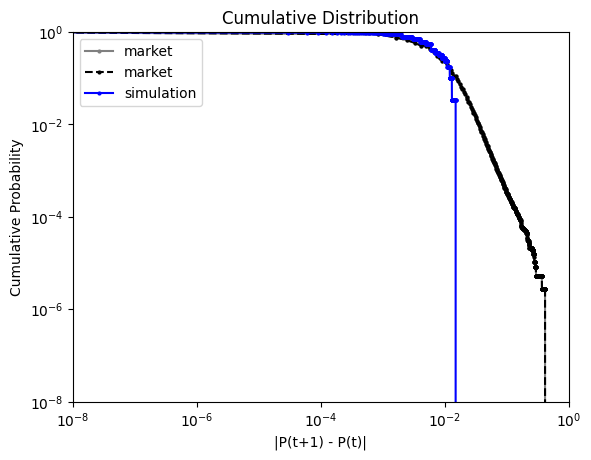

In [204]:
mean = ohlc_min_src.close.mean()
std = ohlc_min_src.close.std()
cumulative, bin_edges = cumulative_dist(ohlc_min_src.close.abs(), bins=500)

mean = ohlc_min_src.close.mean()
std = ohlc_min_src.close.std()
tgt_cumulative, tgt_bin_edges = cumulative_dist(tgt_ohlc_src.close.abs(), bins=500)

mean = ohlc_min_sim_src.price.close.mean()
std = ohlc_min_sim_src.price.close.std()
sim_cumulative, sim_bin_edges = cumulative_dist(ohlc_min_sim_src.price.close.abs(), bins=500)


plt.plot(bin_edges, cumulative, color="gray", marker="o", markersize=2, label="market")
plt.plot(bin_edges, cumulative, color="black", marker="o", markersize=2, label="market", linestyle="--")
plt.plot(sim_bin_edges, sim_cumulative, color="blue", marker="o", markersize=2, label="simulation")

plt.title('Cumulative Distribution')
plt.xlabel('|P(t+1) - P(t)|')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1)
plt.xlim(1e-8, 1)
plt.legend()
plt.show()

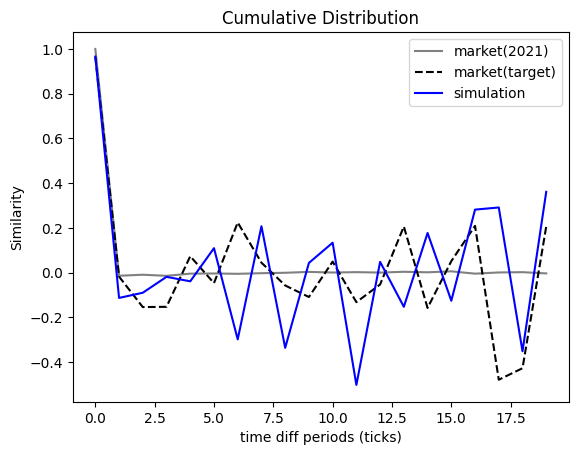

In [205]:
indices, similarities, _ = self_similarity(ohlc_min_src.close, k=20)
tgt_indices, tgt_similarities, _ = self_similarity(tgt_ohlc_src.close, k=20)
sim_indices, sim_similarities, _ = self_similarity(ohlc_min_sim_src.price.close, k=20)


plt.plot(indices, similarities, color="gray", label="market(2021)")
plt.plot(tgt_indices, tgt_similarities, color="black", label="market(target)", linestyle="--")
plt.plot(sim_indices, sim_similarities, color="blue", label="simulation")
plt.title('Cumulative Distribution')
plt.xlabel('time diff periods (ticks)')
plt.ylabel('Similarity')
plt.legend()
plt.show()

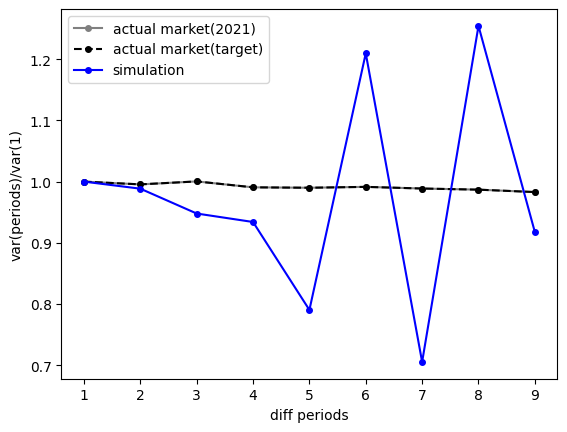

In [206]:
periods = [i for i in range(1, 10)]
var_diffusions = np.array([diffusion(ohlc_min_src.close, period) for period in periods])
std_diffusions = np.sqrt(var_diffusions)

tgt_var_diffusions = np.array([diffusion(tgt_ohlc_src.close, period) for period in periods])
tgt_std_diffusions = np.sqrt(var_diffusions)

sim_var_diffusions = np.array([diffusion(ohlc_min_sim_src.price.close, period) for period in periods])
sim_std_diffusions = np.sqrt(sim_var_diffusions)

# creating ohlc data with noise factor with uniforme distribution is not good
plt.plot(periods, var_diffusions/var_diffusions[0], label="actual market(2021)", color="gray", linestyle="-", marker="o", markersize=4)
plt.plot(periods, var_diffusions/var_diffusions[0], label="actual market(target)", color="black", linestyle="--", marker="o", markersize=4)
plt.plot(periods, sim_var_diffusions/sim_var_diffusions[0], label="simulation", color="blue", linestyle="-", marker="o", markersize=4)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("diff periods")
plt.ylabel("var(periods)/var(1)")
plt.legend()
plt.show()